#Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [ ]:
!pip install pyheif pillow
import os
import pyheif
from PIL import Image

def ensure_directories_exist(directories):
    """Ensure that the given directories exist."""
    for directory in directories:
        os.makedirs(directory, exist_ok=True)

def convert_heic_to_jpeg(heic_file_path, output_folder):
    """Convert a HEIC file to JPEG."""
    try:
        heif_file = pyheif.read(heic_file_path)
        image = Image.frombytes(
            heif_file.mode,
            heif_file.size,
            heif_file.data,
            "raw",
            heif_file.mode,
            heif_file.stride,
        )

        # Generate output file path
        base_name = os.path.basename(heic_file_path)
        output_file_path = os.path.join(output_folder, os.path.splitext(base_name)[0] + '.jpg')

        # Save the converted image
        image.save(output_file_path, "JPEG")
        print(f"Converted and saved: {output_file_path}")
    except Exception as e:
        print(f"Error converting {heic_file_path}: {e}")

def convert_heic_directory(heic_directory, output_directory):
    """Convert all HEIC files in a directory to JPEG format."""
    for filename in os.listdir(heic_directory):
        if filename.lower().endswith(".heic"):
            heic_file_path = os.path.join(heic_directory, filename)
            convert_heic_to_jpeg(heic_file_path, output_directory)

# Define your directory pairs here
directory_pairs = [
    ('/content/drive/MyDrive/new/FRESH', '/content/drive/MyDrive/7TH/Fresh'),
    ('/content/drive/MyDrive/new/UNFRESH', '/content/drive/MyDrive/7TH/Unfresh'),
]

# Ensure all directories exist
input_directories = [pair[0] for pair in directory_pairs]
output_directories = [pair[1] for pair in directory_pairs]
ensure_directories_exist(input_directories + output_directories)

# Process each pair of directories
for input_dir, output_dir in directory_pairs:
    convert_heic_directory(input_dir, output_dir)

#Image Processing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    horizontal_flip=True
)

In [ ]:
# Defining image and batch size
img_size = (256, 256)
batch_size = 32

In [ ]:
# Implementing the datagen class instance created earlier on our images
data_generator = datagen.flow_from_directory('/content/drive/MyDrive/8th',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'  # Set to 'categorical' for multiclass classification
)

Found 370 images belonging to 2 classes.


In [ ]:
#Using the concurrent.futures module to launch parallel tasks of adding images and labels to a list
import concurrent.futures

# Defining a function to process a batch
def process_batch(batch):
    batch_images, batch_labels = data_generator.next()
    return batch_images, batch_labels

num_workers = 8

images = []
labels = []

# Using ThreadPoolExecutor for parallel processing
with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    # Submitting tasks for each batch
    futures = [executor.submit(process_batch, None) for _ in range(len(data_generator))]

    # Retrieving results as they become available
    for future in concurrent.futures.as_completed(futures):
        batch_images, batch_labels = future.result()
        images.extend(batch_images)
        labels.extend(batch_labels)

In [ ]:
labels[0]

array([0., 1.], dtype=float32)

In [ ]:
print(f'Number of images: {len(images)} \nNumber of labels: {len(labels)}')

Number of images: 370 
Number of labels: 370


In [ ]:
import numpy as np

# Convert labels to a NumPy array for easier manipulation
labels = np.array(labels)

# Count the number of images in each class
num_fresh = np.sum(labels[:, 0])  # Assuming class 0 represents 'Fresh'
num_not_fresh = np.sum(labels[:, 1])  # Assuming class 1 represents 'Not Fresh'

# Display the counts
print(f"Number of 'Fresh' images: {num_fresh}")
print(f"Number of 'Not Fresh' images: {num_not_fresh}")


Number of 'Fresh' images: 170.0
Number of 'Not Fresh' images: 200.0


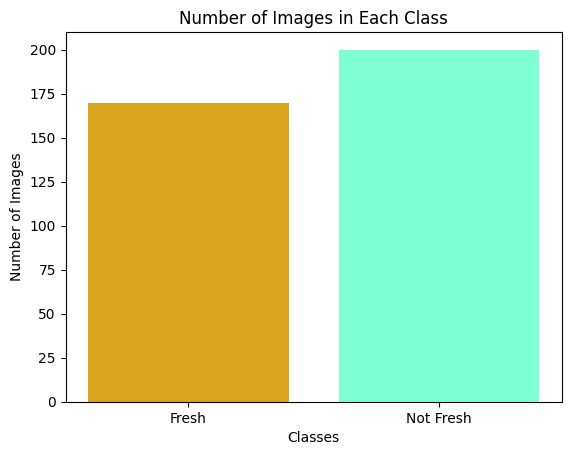

In [ ]:
import matplotlib.pyplot as plt

# Count the number of images in each class
num_fresh = np.sum(labels[:, 0])  # Assuming class 0 represents 'Fresh'
num_not_fresh = np.sum(labels[:, 1])  # Assuming class 1 represents 'Not Fresh'

# Create a bar chart (histogram)
classes = ['Fresh', 'Not Fresh']
counts = [num_fresh, num_not_fresh]

plt.bar(classes, counts, color=['goldenrod', 'aquamarine'])
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.show()


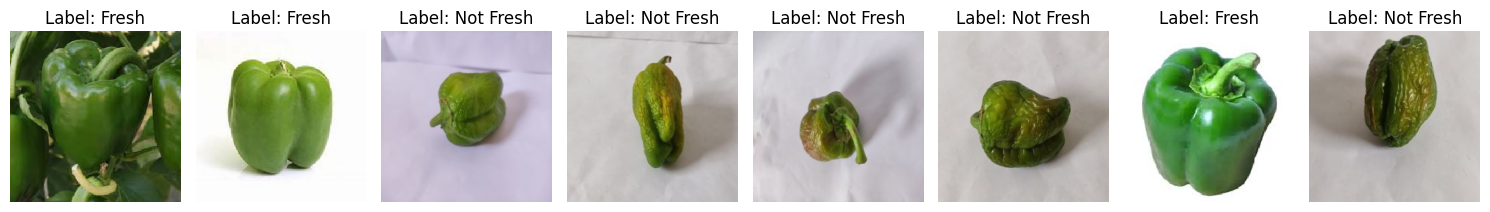

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Sample size for plotting
sample_size = 8

# Randomly selecting a few samples from your dataset
selected_samples = random.sample(range(len(images)), sample_size)

# Creating a subplot with rows and columns
rows = 1
cols = sample_size

# Setting up our subplot
fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
arr1 = np.array([1, 0])
arr2 = np.array([0, 1])

# Plotting selected images in the subplot
for i, ax in zip(selected_samples, axes):
    image = images[i]
    label = labels[i]
    # Assuming images are NumPy arrays
    ax.imshow(image)
    if np.array_equal(label, arr1):
        ax.set_title(f"Label: Fresh")
    elif np.array_equal(label, arr2):
        ax.set_title(f"Label: Not Fresh")
    ax.axis('off')  # Turn off axis labels

plt.tight_layout()
plt.show()


In [ ]:
labels[0]

array([0., 1.], dtype=float32)

#Splitting Training Sets and Validation Sets

In [ ]:
# Dividing dataset to train test and validaiton sets
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Saving images to variable X and corresponding labels to variable y
X = images
y = labels

# Shuffling the data
X, y_encoded = shuffle(X, y, random_state=42)

# Split the data into training, testing, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5)

In [ ]:
import numpy as np

# Convert the lists to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_val = np.array(X_val)
y_val = np.array(y_val)

# Now, you can get the shapes of the datasets
X_train_shape = X_train.shape
y_train_shape = y_train.shape

X_test_shape = X_test.shape
y_test_shape = y_test.shape

X_val_shape = X_val.shape
y_val_shape = y_val.shape

# Print the shapes
print("X_train shape:", X_train_shape)
print("y_train shape:", y_train_shape)
print("X_test shape:", X_test_shape)
print("y_test shape:", y_test_shape)
print("X_val shape:", X_val_shape)
print("y_val shape:", y_val_shape)

X_train shape: (259, 256, 256, 3)
y_train shape: (259, 2)
X_test shape: (55, 256, 256, 3)
y_test shape: (55, 2)
X_val shape: (56, 256, 256, 3)
y_val shape: (56, 2)


In [ ]:
# Converting our data into numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

# Converting test datasets to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
import numpy as np
import pandas as pd

# Sample size for plotting
sample_size = 8

# Randomly selecting a few samples from your dataset
selected_samples = random.sample(range(len(images)), sample_size)

# Create a DataFrame to store the data
data = {'Categorical Label': [], 'One-Hot Encoded Label': []}

# Populate the DataFrame with selected samples
for i in selected_samples:
    categorical_label = None
    one_hot_encoded_label = None

    label = labels[i]  # One-hot encoded label
    if np.array_equal(label, arr1):
        categorical_label = 'Fresh'
    else:  # Combine "Fresh" and "Rotten" into one class
        categorical_label = 'Not Fresh'

    one_hot_encoded_label = label  # Keep the one-hot encoded label as-is

    data['Categorical Label'].append(categorical_label)
    data['One-Hot Encoded Label'].append(one_hot_encoded_label)

# Create a DataFrame from the data
label_matrix_df = pd.DataFrame(data)

# Display the DataFrame
print(label_matrix_df)


  Categorical Label One-Hot Encoded Label
0         Not Fresh            [0.0, 1.0]
1         Not Fresh            [0.0, 1.0]
2             Fresh            [1.0, 0.0]
3         Not Fresh            [0.0, 1.0]
4             Fresh            [1.0, 0.0]
5             Fresh            [1.0, 0.0]
6         Not Fresh            [0.0, 1.0]
7             Fresh            [1.0, 0.0]


#Training Model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

In [ ]:
# Loading pretrained VGG16 model with weights trained on ImageNet data
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [ ]:
y_train.shape

(259, 2)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

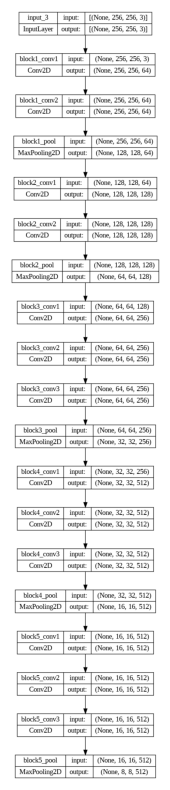

In [ ]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Displaying the model architecture summary
base_model.summary()

# Saving the model architecture plot to a file
plot_model(base_model, to_file='vgg_model_plot.png', show_shapes=True, show_layer_names=True)

# Displaying the personalized model architecture plot within the script
img = mpimg.imread('vgg_model_plot.png')

# Create a figure and axis for custom annotations
fig, ax = plt.subplots(figsize=(10, 10))

# Display the image
ax.imshow(img)
ax.axis('off')

plt.show()

Epoch 1/80
9/9 [==============================] - 29s 3s/step - loss: 0.7284 - accuracy: 0.5869 - val_loss: 0.6355 - val_accuracy: 0.9821
Epoch 2/80
9/9 [==============================] - 2s 215ms/step - loss: 0.7369 - accuracy: 0.5135 - val_loss: 0.5684 - val_accuracy: 0.9821
Epoch 3/80
9/9 [==============================] - 2s 214ms/step - loss: 0.6122 - accuracy: 0.6911 - val_loss: 0.4994 - val_accuracy: 0.9821
Epoch 4/80
9/9 [==============================] - 2s 215ms/step - loss: 0.5627 - accuracy: 0.7529 - val_loss: 0.4295 - val_accuracy: 0.9821
Epoch 5/80
9/9 [==============================] - 2s 267ms/step - loss: 0.4893 - accuracy: 0.8147 - val_loss: 0.3532 - val_accuracy: 0.9821
Epoch 6/80
9/9 [==============================] - 2s 259ms/step - loss: 0.4379 - accuracy: 0.8494 - val_loss: 0.2839 - val_accuracy: 0.9821
Epoch 7/80
9/9 [==============================] - 2s 223ms/step - loss: 0.3543 - accuracy: 0.9151 - val_loss: 0.2249 - val_accuracy: 0.9821
Epoch 8/80
9/9 [======

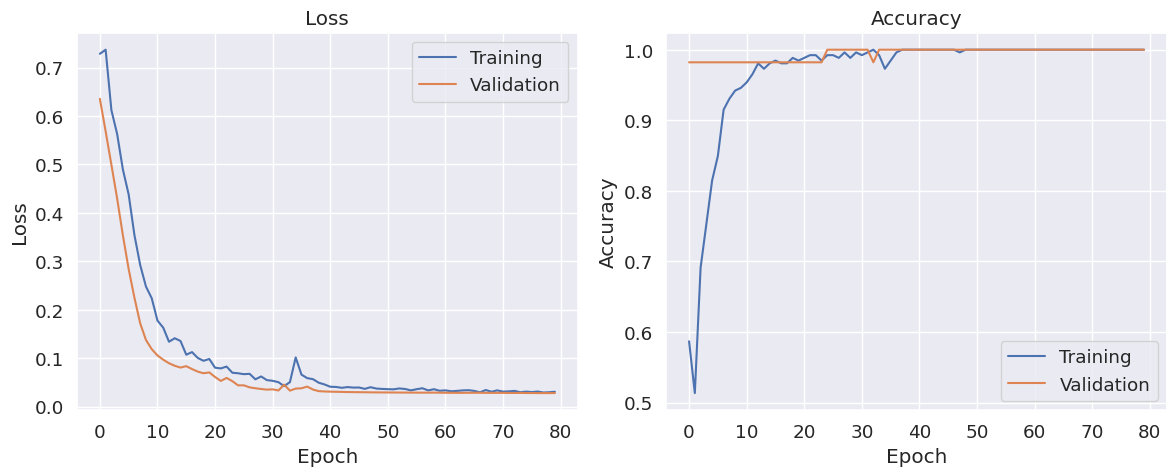

In [ ]:
#WITH FINE TUNING
import tensorflow as tf
from tensorflow.keras.regularizers import l2

# Load the VGG16 base model
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze most of the layers of the base model
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Create your own model on top of VGG16
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.0001))) # Add L2 regularization
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.0001))) # Add L2 regularization
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

# Set the learning rate schedule with decay
initial_learning_rate = 0.00001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
)
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the model with L2 regularization
model.compile(
    optimizer=custom_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Implement early stopping with higher patience
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Fine-tune the top layers of the base model along with the new layers
fine_tune_epochs = 80

# Fit the model and save the training history
history = model.fit(X_train, y_train, epochs=fine_tune_epochs, validation_data=(X_val, y_val), callbacks=[early_stopping])

# After fine-tuning, you can evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Model Performance during training
# Training and validation loss plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Training and validation accuracy plots
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#Testing the Model

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming X_test and y_test are your test set and labels
# X_test = ...
# y_test = ...

# Make predictions
batch_size = 8  # or any other value
y_pred_batches = []

for i in range(0, len(X_test), batch_size):
    batch_predictions = model.predict(X_test[i:i+batch_size])
    y_pred_batches.append(batch_predictions)

y_pred = np.concatenate(y_pred_batches, axis=0)
# Convert predictions to binary indicator matrix
threshold = 0.5  # You can adjust the threshold based on your needs
predicted_classes = (y_pred > threshold).astype(int)

# Ensure y_test is in the correct format for multilabel classification
# y_test = [[1, 0, 1], [0, 1, 0], [1, 1, 1], ...]

# Compute accuracy
accuracy = accuracy_score(y_test, predicted_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Compute precision, recall, and F1-score
precision = precision_score(y_test, predicted_classes, average='weighted')
recall = recall_score(y_test, predicted_classes, average='weighted')
f1 = f1_score(y_test, predicted_classes, average='weighted')

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1 * 100:.2f}%")


1/1 [==============================] - 0s 39ms/step
Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1-score: 100.00%


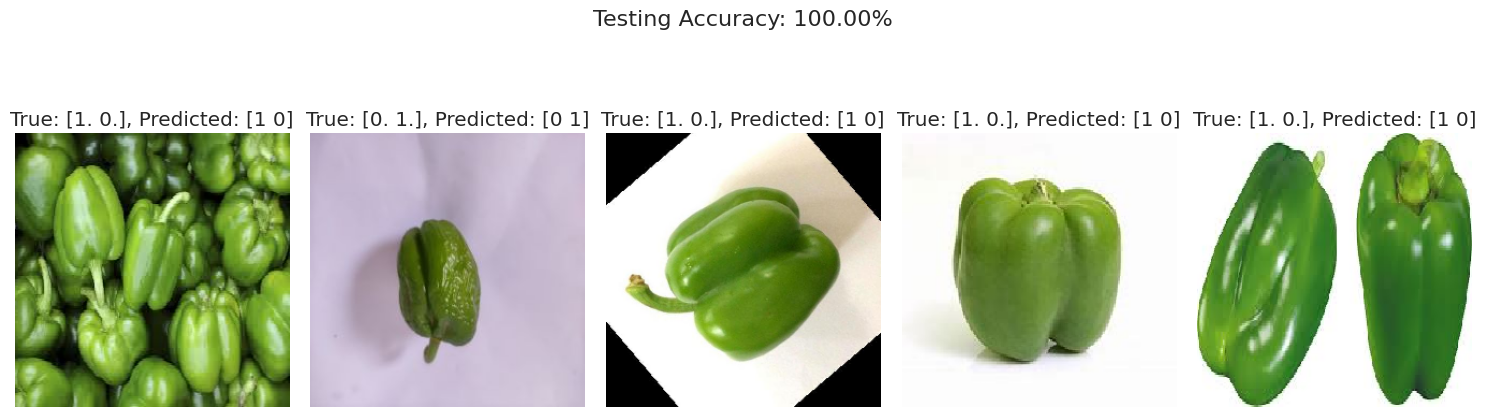

In [ ]:
# We will need to convert the probability values into binary predictions. First we set a threshold value to divide the probability values into corresponding classes
threshold = 0.5
binary_predictions = (y_pred > threshold).astype(int)

# Calculating testing accuracy
test_accuracy = np.sum(binary_predictions.squeeze() == y_test) / len(y_test)

# Sample size for plotting
test_size = 5

# Randomly selecting a few samples from the testing set
test_samples = np.random.choice(range(len(X_test)), test_size, replace=False)

# Now we create a subplot with rows and columns
rows = 1
cols = test_size

# Setting up the subplot
fig, axes = plt.subplots(rows, cols, figsize=(15, 5))

# Plotting the selected images with corresponding predictions of our model
for i, ax in zip(test_samples, axes):
    image = X_test[i]
    true_label = y_test[i]
    predicted_label = binary_predictions[i]
    ax.imshow(image)
    ax.set_title(f"True: {true_label}, Predicted: {predicted_label}")
    ax.axis('off')  # Turning off axis labels as it overlaps with our class labels on the plot

#Display testing accuracy on the plot
fig.suptitle(f"Testing Accuracy: {accuracy * 100:.2f}%", fontsize=16)

#Adjusting layout to prevent clipping
plt.tight_layout(rect=[0, 0.1, 1, 0.9])  # Adjust the top margin to make space for the title
plt.show()

2/2 [==============================] - 0s 186ms/step


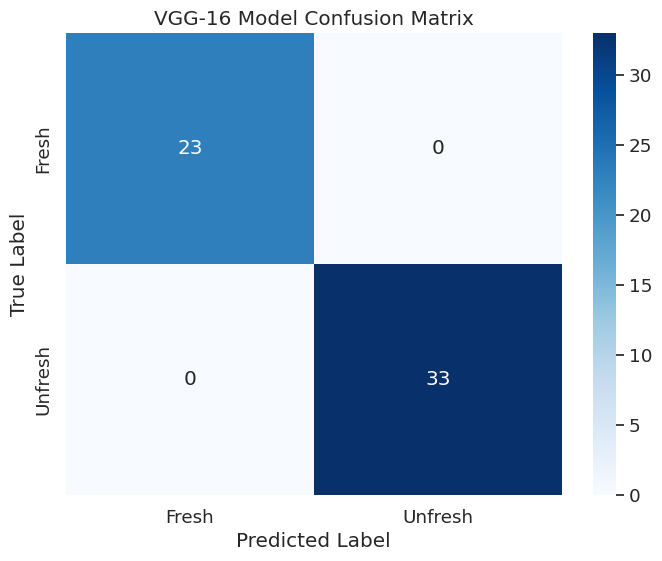

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming you have already trained your model and have predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(np.argmax(y_val, axis=1), y_pred_classes)

# Define the class names (change these to match your classes)
class_names = ['Fresh', 'Unfresh']

# Create a figure and axis for the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('VGG-16 Model Confusion Matrix')

# Show the plot
plt.show()

#Save Model

In [ ]:
from google.colab import files
model.save("../31111vgg(80-20)bellpepperVGG16.h5")
file_name = '/31111vgg(80-20)bellpepperVGG16.h5'

# Provide a download link for the H5 file
files.download(file_name)

In [ ]:
model.save("/content/MyDrive/31111vgg(80-20)bellpepperVGG16.h5")